# 特徴量作成 2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import datetime
import os
import calendar
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import utils

In [4]:
import sys
sys.path.append("../common")
import common_utils

In [5]:
IN_DIRECTORY = '../data/processed'
# OUT_DIRECTORY = './processed'

In [6]:
# os.makedirs(OUT_DIRECTORY, exist_ok=True)

## 準備

In [7]:
symbol = "usdjpy"
year_from = 2019
month_from = 10
year_to = 2019
month_to = 12

In [8]:
df_org = utils.read_processed_data_range(symbol, year_from, month_from, year_to, month_to)

In [9]:
assert (df_org.index[0].hour, df_org.index[0].minute) == (0, 0)
assert (df_org.index[-1].hour, df_org.index[-1].minute) == (23, 59)

In [10]:
df_org.head()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close
timestamp,,,,,,,,
2019-10-01 00:00:00,108.071,108.074,108.071,108.074,108.095,108.099,108.089,108.098
2019-10-01 00:01:00,108.075,108.075,108.071,108.072,108.098,108.099,108.098,108.099
2019-10-01 00:02:00,108.074,108.074,108.071,108.071,108.098,108.098,108.098,108.098
2019-10-01 00:03:00,108.071,108.072,108.071,108.072,108.101,108.101,108.098,108.098
2019-10-01 00:04:00,108.077,108.077,108.077,108.077,108.094,108.094,108.094,108.094


In [11]:
df_org.tail()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close
timestamp,,,,,,,,
2019-12-31 23:55:00,108.643,108.655,108.643,108.653,108.654,108.661,108.652,108.660
2019-12-31 23:56:00,108.659,108.669,108.659,108.666,108.661,108.677,108.661,108.672
2019-12-31 23:57:00,108.668,108.675,108.665,108.667,108.673,108.682,108.673,108.679
2019-12-31 23:58:00,108.667,108.673,108.619,108.619,108.678,108.685,108.676,108.685
2019-12-31 23:59:00,108.619,108.631,108.613,108.631,108.683,108.684,108.680,108.683


In [175]:
df = pd.DataFrame({
    "open": (df_org["bid_open"] + df_org["ask_open"]) / 2,
    "high": (df_org["bid_high"] + df_org["ask_high"]) / 2,
    "low": (df_org["bid_low"] + df_org["ask_low"]) / 2,
    "close": (df_org["bid_close"] + df_org["ask_close"]) / 2,
}, index=df_org.index)

In [176]:
df = df.add_suffix("_1min")

In [177]:
df.head()

,open_1min,high_1min,low_1min,close_1min
timestamp,,,,
2019-10-01 00:00:00,108.0830,108.0865,108.0800,108.0860
2019-10-01 00:01:00,108.0865,108.0870,108.0845,108.0855
2019-10-01 00:02:00,108.0860,108.0860,108.0845,108.0845
2019-10-01 00:03:00,108.0860,108.0865,108.0845,108.0850
2019-10-01 00:04:00,108.0855,108.0855,108.0855,108.0855


## 調整

In [96]:
freqs = ["1min", "5min", "15min", "30min", "1h", "4h", "1d"]

In [98]:
freq = "1min"
lookahead = 15
threshold = 0.02
# threshold_soft = -0.005
# threshold_strict = 0.02
# threshold_loose = -0.01
# test_fraction = 0.2

In [99]:
if freq == "1min":
    df_agg = df.copy()
else:
    df_agg = pd.concat({
        f"open_{freq}": utils.aggregate_time(df["open_1min"], freq, how="first"),
        f"high_{freq}": utils.aggregate_time(df["high_1min"], freq, how="max"),
        f"low_{freq}": utils.aggregate_time(df["low_1min"], freq, how="min"),
        f"close_{freq}": utils.aggregate_time(df["close_1min"], freq, how="last"),
    }, axis=1)

In [100]:
max_high = df_agg[f"high_{freq}"].rolling(lookahead).max().shift(-lookahead)
max_low = df_agg[f"low_{freq}"].rolling(lookahead).max().shift(-lookahead)
min_high = df_agg[f"high_{freq}"].rolling(lookahead).min().shift(-lookahead)
min_low = df_agg[f"low_{freq}"].rolling(lookahead).min().shift(-lookahead)

In [101]:
uptrend = (
    (max_high - df_agg[f"high_{freq}"] > threshold) &
    (max_low - df_agg[f"low_{freq}"] > threshold) &
    (min_high - df_agg[f"high_{freq}"] >= 0) &
    (min_low - df_agg[f"low_{freq}"] >= 0)
)
downtrend = (
    (min_high - df_agg[f"high_{freq}"] < -threshold) &
    (min_low - df_agg[f"low_{freq}"] < -threshold) &
    (max_high - df_agg[f"high_{freq}"] <= 0) &
    (max_low - df_agg[f"low_{freq}"] <= 0)
)

In [102]:
print("uptrend ratio: ", uptrend.mean())
print("downtrend ratio: ", downtrend.mean())

uptrend ratio:  0.07614649681528662
downtrend ratio:  0.07370488322717622


In [103]:
# uptrend_soft = (
#     (max_high - df_agg[f"high_{freq}"] > 0) &
#     (max_low - df_agg[f"low_{freq}"] > 0) &
#     (min_high - df_agg[f"high_{freq}"] > threshold_soft) &
#     (min_low - df_agg[f"low_{freq}"] > threshold_soft)
# )
# downtrend_soft = (
#     (min_high - df_agg[f"high_{freq}"] < 0) &
#     (min_low - df_agg[f"low_{freq}"] < 0) &
#     (max_high - df_agg[f"high_{freq}"] < -threshold_soft) &
#     (max_low - df_agg[f"low_{freq}"] < -threshold_soft)
# )

In [104]:
# print("uptrend_soft ratio: ", uptrend_soft.mean())
# print("downtrend_soft ratio: ", downtrend_soft.mean())

In [106]:
# assert not (uptrend & ~uptrend_soft).any()
# assert not (downtrend & ~downtrend_soft).any()

In [107]:
# (uptrend_soft & downtrend_soft).mean()

In [59]:
start_datetime = "2019-11-01 00:00:00"
end_datetime = "2019-11-01 23:59:59"
df_plot = pd.DataFrame({
    "high": df_agg[f"high_{freq}"],
    "low": df_agg[f"low_{freq}"],
    "uptrend": uptrend,
    "downtrend": downtrend,
}).loc[start_datetime:end_datetime]

In [60]:
df_plot.head()

,high,low,uptrend,downtrend
timestamp,,,,
2019-11-01 00:00:00,108.0390,108.0300,False,False
2019-11-01 00:01:00,108.0390,108.0345,False,False
2019-11-01 00:02:00,108.0400,108.0370,False,False
2019-11-01 00:03:00,108.0405,108.0355,False,False
2019-11-01 00:04:00,108.0430,108.0345,False,False


In [61]:
def plot_bool_series(fig, s: pd.Series, fillcolor: str):
    v = s.values
    start_idxs = np.nonzero((~v[:-1]) & v[1:])[0] + 1
    end_idxs = np.nonzero(v[:-1] & (~v[1:]))[0] + 1
    if v[0]:
        start_idxs = [0, *start_idxs]
    if v[-1]:
        end_idxs = [*end_idxs, len(v) - 1]

    assert len(start_idxs) == len(end_idxs)

    for si, ei in zip(start_idxs, end_idxs):
        fig.add_vrect(x0=s.index[si], x1=s.index[ei], line_width=0, opacity=0.2, fillcolor=fillcolor)

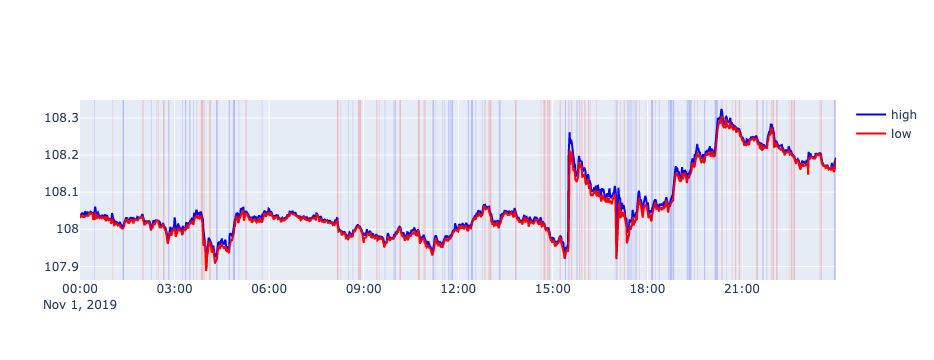

In [62]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot["high"], name="high", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot["low"], name="low", line=dict(color="red")))

plot_bool_series(fig, df_plot["uptrend"], fillcolor="blue")
plot_bool_series(fig, df_plot["downtrend"], fillcolor="red")
# plot_bool_series(fig, df_plot["uptrend_soft"], fillcolor="lightblue")
# plot_bool_series(fig, df_plot["downtrend_soft"], fillcolor="orangered")
fig.show()

## ラベル作成

### トレンド判定

In [178]:
freqs = ["1min", "5min", "15min", "30min", "1h", "4h", "1d"]
lookahead = 15
# threshold_strict = 0.02
# threshold_loose = -0.01
# test_fraction = 0.2
threshold = 0.02
threshold_soft = 0.01

In [179]:
# for freq, tp in zip(freqs, threshold_pips):
for freq in freqs:
    print(f"freq = {freq}")

    if freq == "1min":
        df_agg = df.copy()
    else:
        df_agg = pd.concat({
            f"open_{freq}": utils.aggregate_time(df["open_1min"], freq, how="first"),
            f"high_{freq}": utils.aggregate_time(df["high_1min"], freq, how="max"),
            f"low_{freq}": utils.aggregate_time(df["low_1min"], freq, how="min"),
            f"close_{freq}": utils.aggregate_time(df["close_1min"], freq, how="last"),
        }, axis=1)
    
#     quantile_high = df_agg[f"high_{freq}"].rolling(lookahead).quantile(1-test_fraction).shift(-lookahead+1)
#     quantile_low = df_agg[f"low_{freq}"].rolling(lookahead).quantile(1-test_fraction).shift(-lookahead+1)
#     min_high = df_agg[f"high_{freq}"].rolling(lookahead).min().shift(-lookahead+1)
#     min_low = df_agg[f"low_{freq}"].rolling(lookahead).min().shift(-lookahead+1)
#     uptrend = (
#         (quantile_high - df_agg[f"high_{freq}"] > threshold_strict) &
#         (quantile_low - df_agg[f"low_{freq}"] > threshold_strict) &
#         (min_high - df_agg[f"high_{freq}"] > threshold_loose) &
#         (min_low - df_agg[f"low_{freq}"] > threshold_loose)
#     )

#     quantile_high = df_agg[f"high_{freq}"].rolling(lookahead).quantile(test_fraction).shift(-lookahead+1)
#     quantile_low = df_agg[f"low_{freq}"].rolling(lookahead).quantile(test_fraction).shift(-lookahead+1)
#     max_high = df_agg[f"high_{freq}"].rolling(lookahead).max().shift(-lookahead+1)
#     max_low = df_agg[f"low_{freq}"].rolling(lookahead).max().shift(-lookahead+1)
#     downtrend = (
#         (quantile_high - df_agg[f"high_{freq}"] < -threshold_strict) &
#         (quantile_low - df_agg[f"low_{freq}"] < -threshold_strict) &
#         (max_high - df_agg[f"high_{freq}"] < -threshold_loose) &
#         (max_low - df_agg[f"low_{freq}"] < -threshold_loose)
#     )

    max_high = df_agg[f"high_{freq}"].rolling(lookahead).max().shift(-lookahead)
    max_low = df_agg[f"low_{freq}"].rolling(lookahead).max().shift(-lookahead)
    min_high = df_agg[f"high_{freq}"].rolling(lookahead).min().shift(-lookahead)
    min_low = df_agg[f"low_{freq}"].rolling(lookahead).min().shift(-lookahead)
    
    uptrend = (
        (max_high - df_agg[f"high_{freq}"] > threshold) &
        (max_low - df_agg[f"low_{freq}"] > threshold) &
        (min_high - df_agg[f"high_{freq}"] >= 0) &
        (min_low - df_agg[f"low_{freq}"] >= 0)
    )
    downtrend = (
        (min_high - df_agg[f"high_{freq}"] < -threshold) &
        (min_low - df_agg[f"low_{freq}"] < -threshold) &
        (max_high - df_agg[f"high_{freq}"] <= 0) &
        (max_low - df_agg[f"low_{freq}"] <= 0)
    )
    print("uptrend ratio: ", uptrend.mean())
    print("downtrend ratio: ", downtrend.mean())
    df_agg[f"uptrend_{freq}"] = uptrend
    df_agg[f"downtrend_{freq}"] = downtrend
    
    uptrend_soft = (
        (max_high - df_agg[f"high_{freq}"] > threshold_soft) &
        (max_low - df_agg[f"low_{freq}"] > threshold_soft)
    )
    downtrend_soft = (
        (min_high - df_agg[f"high_{freq}"] < -threshold_soft) &
        (min_low - df_agg[f"low_{freq}"] < -threshold_soft)
    )
    # uptrend_soft = (
    #     (max_high - df_agg[f"high_{freq}"] > 0) &
    #     (max_low - df_agg[f"low_{freq}"] > 0) &
    #     (min_high - df_agg[f"high_{freq}"] > threshold_soft) &
    #     (min_low - df_agg[f"low_{freq}"] > threshold_soft)
    # )
    # downtrend_soft = (
    #     (min_high - df_agg[f"high_{freq}"] < 0) &
    #     (min_low - df_agg[f"low_{freq}"] < 0) &
    #     (max_high - df_agg[f"high_{freq}"] < -threshold_soft) &
    #     (max_low - df_agg[f"low_{freq}"] < -threshold_soft)
    # )
    print("uptrend_soft ratio: ", uptrend_soft.mean())
    print("downtrend_soft ratio: ", downtrend_soft.mean())
    df_agg[f"uptrend_soft_{freq}"] = uptrend_soft
    df_agg[f"downtrend_soft_{freq}"] = downtrend_soft

    if freq == "1min":
        # df_to_add = df_agg[["uptrend_1min", "downtrend_1min"]]
        df_to_add = df_agg[["uptrend_1min", "downtrend_1min", "uptrend_soft_1min", "downtrend_soft_1min"]]
    else:
        df_to_add = df_agg.reindex(df.index, method="ffill")

    df = pd.concat([df, df_to_add], axis=1)

freq = 1min
uptrend ratio:  0.07614649681528662
downtrend ratio:  0.07370488322717622
uptrend_soft ratio:  0.4537048832271762
downtrend_soft ratio:  0.4458492569002123
freq = 5min
uptrend ratio:  0.0963375796178344
downtrend ratio:  0.09198513800424628
uptrend_soft ratio:  0.6286093418259023
downtrend_soft ratio:  0.6071125265392782
freq = 15min
uptrend ratio:  0.09840764331210192
downtrend ratio:  0.08917197452229299
uptrend_soft ratio:  0.6926751592356688
downtrend_soft ratio:  0.6648089171974523
freq = 30min
uptrend ratio:  0.09904458598726115
downtrend ratio:  0.08248407643312101
uptrend_soft ratio:  0.7305732484076433
downtrend_soft ratio:  0.7022292993630573
freq = 1h
uptrend ratio:  0.08917197452229299
downtrend ratio:  0.07770700636942675
uptrend_soft ratio:  0.767515923566879
downtrend_soft ratio:  0.729936305732484
freq = 4h
uptrend ratio:  0.11959287531806616
downtrend ratio:  0.05597964376590331
uptrend_soft ratio:  0.7760814249363868
downtrend_soft ratio:  0.69465648854961

In [180]:
df.head()

,open_1min,high_1min,low_1min,close_1min,uptrend_1min,downtrend_1min,uptrend_soft_1min,downtrend_soft_1min,open_5min,high_5min,...,uptrend_soft_4h,downtrend_soft_4h,open_1d,high_1d,low_1d,close_1d,uptrend_1d,downtrend_1d,uptrend_soft_1d,downtrend_soft_1d
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:00:00,108.0830,108.0865,108.0800,108.0860,False,False,True,False,108.083,108.087,...,True,True,108.083,108.471,107.6275,107.7485,False,False,True,True
2019-10-01 00:01:00,108.0865,108.0870,108.0845,108.0855,False,False,True,False,108.083,108.087,...,True,True,108.083,108.471,107.6275,107.7485,False,False,True,True
2019-10-01 00:02:00,108.0860,108.0860,108.0845,108.0845,False,False,True,False,108.083,108.087,...,True,True,108.083,108.471,107.6275,107.7485,False,False,True,True
2019-10-01 00:03:00,108.0860,108.0865,108.0845,108.0850,False,False,True,False,108.083,108.087,...,True,True,108.083,108.471,107.6275,107.7485,False,False,True,True
2019-10-01 00:04:00,108.0855,108.0855,108.0855,108.0855,False,False,True,False,108.083,108.087,...,True,True,108.083,108.471,107.6275,107.7485,False,False,True,True


In [181]:
df.columns

Index(['open_1min', 'high_1min', 'low_1min', 'close_1min', 'uptrend_1min',
       'downtrend_1min', 'uptrend_soft_1min', 'downtrend_soft_1min',
       'open_5min', 'high_5min', 'low_5min', 'close_5min', 'uptrend_5min',
       'downtrend_5min', 'uptrend_soft_5min', 'downtrend_soft_5min',
       'open_15min', 'high_15min', 'low_15min', 'close_15min', 'uptrend_15min',
       'downtrend_15min', 'uptrend_soft_15min', 'downtrend_soft_15min',
       'open_30min', 'high_30min', 'low_30min', 'close_30min', 'uptrend_30min',
       'downtrend_30min', 'uptrend_soft_30min', 'downtrend_soft_30min',
       'open_1h', 'high_1h', 'low_1h', 'close_1h', 'uptrend_1h',
       'downtrend_1h', 'uptrend_soft_1h', 'downtrend_soft_1h', 'open_4h',
       'high_4h', 'low_4h', 'close_4h', 'uptrend_4h', 'downtrend_4h',
       'uptrend_soft_4h', 'downtrend_soft_4h', 'open_1d', 'high_1d', 'low_1d',
       'close_1d', 'uptrend_1d', 'downtrend_1d', 'uptrend_soft_1d',
       'downtrend_soft_1d'],
      dtype='object')

In [182]:
(df.isnull().sum() == 0).all()

True

### ラベル付け

- entry

    上昇トレンドなら買い, 下降トレンドなら売り

- exit



In [183]:
df["long_entry"] = df["uptrend_1min"]
df["short_entry"] = df["downtrend_1min"]

In [75]:
# trend_first = pd.Series(np.zeros(len(df)), index=df.index)
# for freq in freqs:
#     trend_first[(trend_first == 0) & df[f"uptrend_{freq}"]] = 1
#     trend_first[(trend_first == 0) & df[f"downtrend_{freq}"]] = -1

In [76]:
# df["long_exit"] = (trend_first != 1)
# df["short_exit"] = (trend_first != -1)

In [128]:
# for freq in freqs:
#     print(freq)
#     print(df[f"uptrend_soft_{freq}"].mean(), df[f"downtrend_soft_{freq}"].mean())

In [184]:
df["long_exit"] = pd.Series(np.ones(len(df), dtype=bool), index=df.index)
df["short_exit"] = pd.Series(np.ones(len(df), dtype=bool), index=df.index)
for freq in freqs:
    df["long_exit"] &= ~df[f"uptrend_soft_{freq}"]
    df["short_exit"] &= ~df[f"downtrend_soft_{freq}"]

In [185]:
df[["long_entry", "short_entry"]].mean()

long_entry     0.076146
short_entry    0.073705
dtype: float64

In [186]:
df[["long_exit", "short_exit"]].mean()

long_exit     0.022335
short_exit    0.039766
dtype: float64

In [187]:
assert not (df["long_entry"] & df["long_exit"]).any()
assert not (df["short_entry"] & df["short_exit"]).any()

## 実績シミュレーション

In [189]:
loss_cut_threshold = 0.05

In [190]:
order_manager = common_utils.OrderManager()

for i in range(len(df)):
    timestamp = df.index[i]
    
    if not order_manager.has_position():
        # 厳し目の見積もりをする
        current_rate_long = df["high_1min"][i]
        current_rate_short = df["low_1min"][i]

        if df["long_entry"][i]:
            order_manager.entry("long", timestamp, current_rate_long)
            print(timestamp, "long entry")
        elif df["short_entry"][i]:
            order_manager.entry("short", timestamp, current_rate_short)
            print(timestamp, "short entry")
    else:
        end_of_day = (timestamp.hour, timestamp.minute) == (23, 59)

        # 厳し目の見積もりをする
        current_rate_long = df["low_1min"][i]
        current_rate_short = df["high_1min"][i]

        open_position = order_manager.open_position
        loss_cut_long = open_position.entry_rate - current_rate_long > loss_cut_threshold
        loss_cut_short = current_rate_short - open_position.entry_rate > loss_cut_threshold

        if open_position.position_type == "long" and (df["long_exit"][i] or end_of_day or loss_cut_long):
            order_manager.exit("long", timestamp, current_rate_long)
            print(timestamp, "long exit")
        elif open_position.position_type == "short" and (df["short_exit"][i] or end_of_day or loss_cut_short):
            order_manager.exit("short", timestamp, current_rate_short)
            print(timestamp, "short exit")

2019-10-01 00:18:00 short entry
2019-10-01 03:54:00 short exit
2019-10-01 04:14:00 long entry
2019-10-01 17:01:00 long exit
2019-10-01 17:02:00 short entry
2019-10-01 23:59:00 short exit
2019-10-02 01:15:00 short entry
2019-10-02 06:03:00 short exit
2019-10-02 06:35:00 long entry
2019-10-02 09:59:00 long exit
2019-10-02 10:06:00 short entry
2019-10-02 23:59:00 short exit
2019-10-03 00:08:00 short entry
2019-10-03 09:53:00 short exit
2019-10-03 10:06:00 long entry
2019-10-03 11:42:00 long exit
2019-10-03 11:44:00 short entry
2019-10-03 17:07:00 short exit
2019-10-03 17:08:00 long entry
2019-10-03 23:59:00 long exit
2019-10-04 00:10:00 short entry
2019-10-04 14:47:00 short exit
2019-10-04 14:58:00 long entry
2019-10-04 15:30:00 long exit
2019-10-04 15:31:00 long entry
2019-10-04 17:49:00 long exit
2019-10-04 17:55:00 short entry
2019-10-04 23:59:00 short exit
2019-10-07 00:05:00 long entry
2019-10-07 23:59:00 long exit
2019-10-08 00:15:00 short entry
2019-10-08 03:07:00 short exit
2019-1

In [191]:
days = (df.index[-1] - df.index[0]).days * (5/7)
print(f"days = {days}")
print(f"1日あたりの平均オーダー数: {len(order_manager.order_history) / days}")

days = 65.0
1日あたりの平均オーダー数: 3.4307692307692306


### 利得

In [192]:
spread = 0.02
profits = []
for order in order_manager.order_history:
    if order.position_type == "long":
        profits.append(order.exit_rate - order.entry_rate - spread)
    elif order.position_type == "short":
        profits.append(order.entry_rate - order.exit_rate - spread)

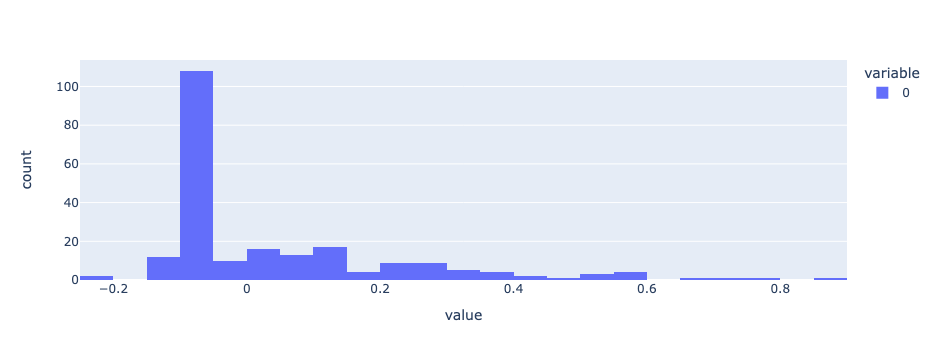

In [193]:
px.histogram(profits)

In [194]:
np.mean(profits), np.sum(profits)

(0.042928251121077746, 9.573000000000338)

### 決済までの時間

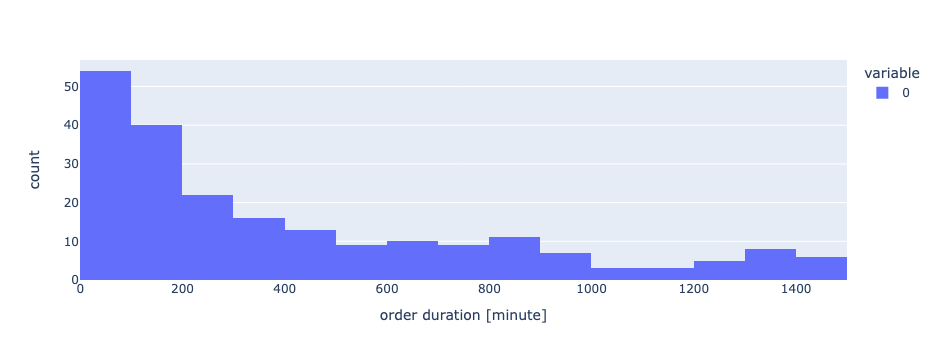

In [172]:
timedeltas = pd.Series([order.exit_timestamp - order.entry_timestamp for order in order_manager.order_history])
fig = px.histogram(timedeltas.dt.seconds // 60)
fig.update_layout(xaxis_title="order duration [minute]")

In [173]:
timedeltas.min(), timedeltas.median(), timedeltas.mean(), timedeltas.max()

(Timedelta('0 days 00:01:00'),
 Timedelta('0 days 04:42:30'),
 Timedelta('0 days 07:07:30'),
 Timedelta('1 days 00:39:00'))

### 取引の可視化

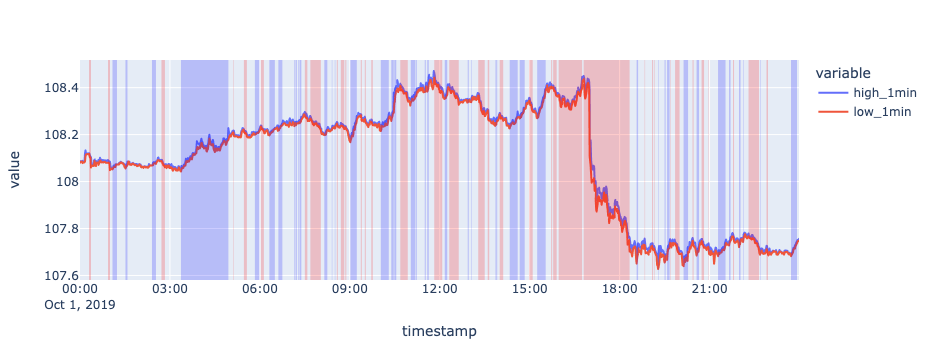

In [151]:
plot_date = "2019-10-01"
start_datetime = pd.Timestamp(plot_date + " 00:00:00")
end_datetime = pd.Timestamp(plot_date + " 23:59:59")

fig = px.line(df.loc[plot_date, ["high_1min", "low_1min"]])

for order in order_manager.order_history:
    if order.entry_timestamp < start_datetime or order.exit_timestamp > end_datetime:
        continue

    fillcolor = "blue" if order.position_type == "long" else "red"
    fig.add_vrect(x0=order.entry_timestamp, x1=order.exit_timestamp, line_width=0, opacity=0.2, fillcolor=fillcolor)

fig.show()

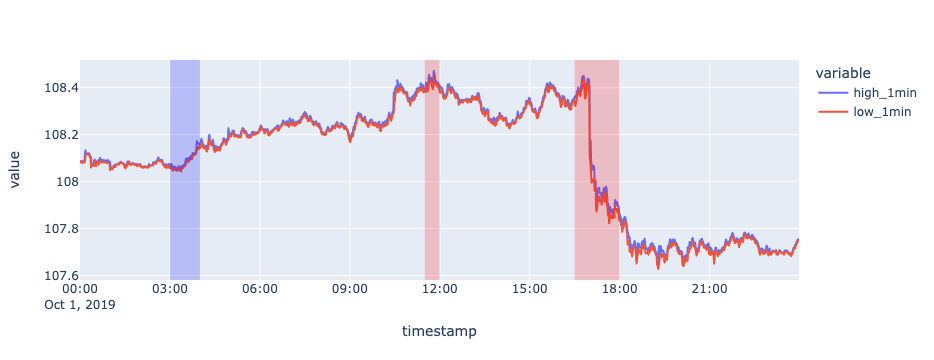

In [152]:
freq = "30min"
uptrend = df.loc[plot_date, f"uptrend_{freq}"]
downtrend = df.loc[plot_date, f"downtrend_{freq}"]

fig = px.line(df.loc[plot_date, ["high_1min", "low_1min"]])
plot_bool_series(fig, uptrend, "blue")
plot_bool_series(fig, downtrend, "red")
fig.show()

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94200 entries, 2019-10-01 00:00:00 to 2019-12-31 23:59:00
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open_1min             94200 non-null  float64
 1   high_1min             94200 non-null  float64
 2   low_1min              94200 non-null  float64
 3   close_1min            94200 non-null  float64
 4   uptrend_1min          94200 non-null  bool   
 5   downtrend_1min        94200 non-null  bool   
 6   uptrend_soft_1min     94200 non-null  bool   
 7   downtrend_soft_1min   94200 non-null  bool   
 8   open_5min             94200 non-null  float64
 9   high_5min             94200 non-null  float64
 10  low_5min              94200 non-null  float64
 11  close_5min            94200 non-null  float64
 12  uptrend_5min          94200 non-null  bool   
 13  downtrend_5min        94200 non-null  bool   
 14  uptrend_soft_5min     94200 non-nul

In [92]:
year = 5
lag = 20
factor = 1/2 /2
print(25 * 4 * year * lag * factor / 1000, "GB")

2.5 GB
